In [13]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import heapq
import time

In [14]:
df = pd.read_csv('ca-GrQc.csv')
# df = pd.read_csv('social network dataset/facebook_combined.csv')
G = nx.from_pandas_edgelist(df, source='Source', target='Target', create_using=nx.Graph())

p = 0.2
for u, v in G.edges():
    G[u][v]['weight'] = p

print(G.number_of_nodes(), G.number_of_edges())

5242 14496


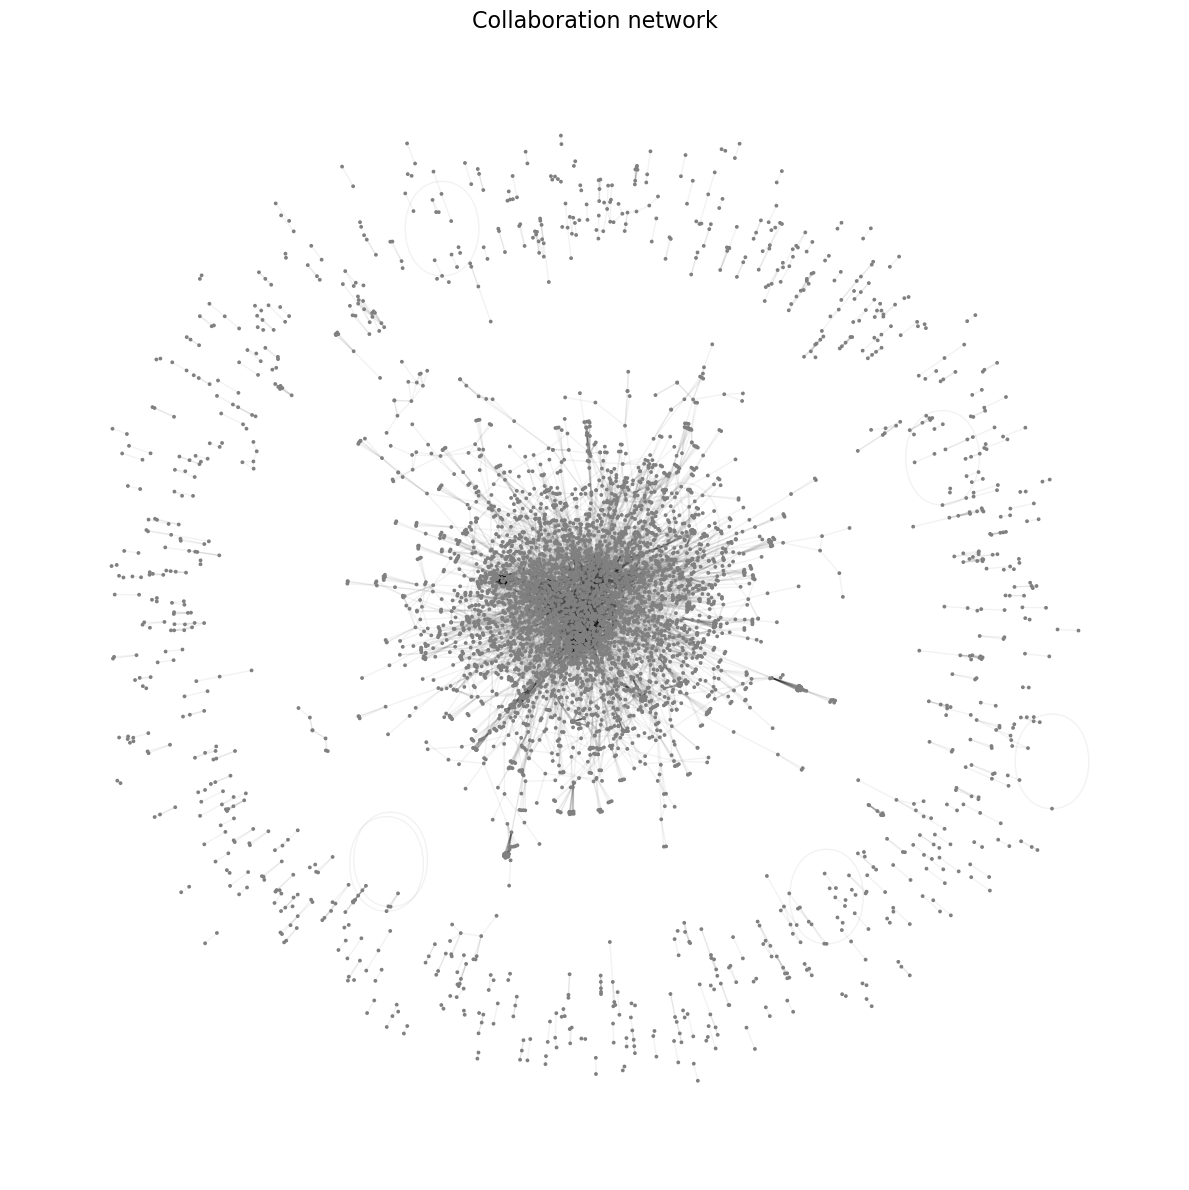

In [3]:
plt.figure(figsize=(12, 12))
node_colors = []
for n in G.nodes():
    node_colors.append("gray")

pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3)
nx.draw_networkx_edges(G, pos, alpha=0.05, width=1)

plt.title(f"Collaboration network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

Independent Cascade Model

In [15]:
def independent_cascade(G, seeds, steps=10):
    activated = set(seeds)
    newly = list(seeds)
    for _ in range(steps):
        next_new = []
        for u in newly:
            for v in G.neighbors(u):
                if v not in activated and random.random() <= G[u][v]['weight']:
                    activated.add(v)
                    next_new.append(v)
        if not next_new:
            break
        newly = next_new
    return activated

# Monte Carlo estimation of spread
def estimate_spread(G, seeds, steps=10, mc_runs=20):
    total = 0
    for _ in range(mc_runs):
        total += len(independent_cascade(G, seeds, steps))
    return total / mc_runs

# Greedy seed selection
def greedy_seeds(G, k, steps=10, mc_runs=10):
    S = []
    spread_S = 0.0
    candidates = set(G.nodes())
    for i in range(k):
        # print(f"Greedy round {i+1}/{k}...")
        best, best_gain = None, 0.0
        for v in candidates - set(S):
            gain = estimate_spread(G, S + [v], steps, mc_runs) - spread_S
            # if gain > best_gain:
            best_gain, best = gain, v
        S.append(best)
        spread_S += best_gain
        # print(f"Greedy round {i+1}: pick {best}, marginal gain={best_gain:.2f}")
    return S

# CELF (Cost-Effective Lazy Forward) seed selection
def celf_seeds(G, k, steps=10, mc_runs=20):

    heap = []
    for v in G.nodes():
        spread_v = estimate_spread(G, [v], steps, mc_runs)
        heap.append((-spread_v, v, 0))
    heapq.heapify(heap)

    S = [] #selected seeds
    spread_S = 0.0 #selected seeds spread
    lookups = 0  # number of re-evaluations

    # choose k seeds using CELF
    for round_i in range(1, k+1):
        while True:
            neg_gain, v, prev_round = heapq.heappop(heap)
            gain = -neg_gain
            # if this node v was selected in the previous round
            if prev_round == round_i - 1:
                S.append(v)
                spread_S += gain
                # print(f"CELF round {round_i}: pick {v}, marginal gain={gain:.2f}")
                break
            else:
                # re-evaluate the gain of v
                lookups += 1
                new_gain = estimate_spread(G, S + [v], steps, mc_runs) - spread_S
                # push the updated gain back to the heap
                heapq.heappush(heap, (-new_gain, v, round_i - 1))

        # 选完 v 之后，继续下一轮

    # print(f"Total re-evaluations: {lookups} (should be ≪ k·n)")
    return S

# M-Greedy(with CELF) seed selection
def m_greedy_seeds(G, k, steps=10, mc_runs=20):
    # Step 1: compute individual influence δ(v)
    delta = {v: estimate_spread(G, [v], steps, mc_runs) for v in G.nodes()}
    avg_infl = sum(delta.values()) / len(delta)
    # Step 2: filter nodes with δ(v) >= average
    candidates = [v for v, d in delta.items() if d >= avg_infl]
    G_sub = G.subgraph(candidates).copy()
    # Step 3: run CELF-greedy on reduced graph
    S = celf_seeds(G_sub, k, steps, mc_runs)
    return S

def d_greedy_seeds(G, k, Rs=100):
    # 1) 采样 Rs 个无向快照：每条边以 p 保留
    snapshots = []
    for _ in range(Rs):
        SG = nx.Graph()
        SG.add_nodes_from(G.nodes())
        for u, v, data in G.edges(data=True):
            if random.random() <= data['weight']:
                SG.add_edge(u, v)
        snapshots.append(SG)

    S = []  # 最终种子集
    # 对每个快照，记录当前 A 在该快照上可达的节点集合
    reachable = [set() for _ in range(Rs)]

    # 2) 迭代选 k 个种子
    for i in range(1, k+1):
        best_v, best_gain = None, -1.0

        # 对每个候选节点 v 计算增益 H_v
        for v in G.nodes():
            if v in S:
                continue
            total_gain = 0
            for j, SG in enumerate(snapshots):
                comp = nx.node_connected_component(SG, v)
                # 新增增益是 v 的连通分量去除已达集合后的大小
                total_gain += len(comp - reachable[j])
            H_v = total_gain / Rs

            if H_v > best_gain:
                best_gain, best_v = H_v, v

        # 3) 选中 best_v 并更新 reachable
        S.append(best_v)
        # print(f"D-greedy round {i}: pick {best_v}, marginal gain={best_gain:.2f}")
        for j, SG in enumerate(snapshots):
            reachable[j] |= nx.node_connected_component(SG, best_v)

    return S

# Degree Discount IC seed selection
def degree_discount_ic(G, k, p):
    deg = {v: G.degree(v) for v in G.nodes()}
    t = {v: 0 for v in G.nodes()} # num of neighbors already activated
    dd = deg.copy() # Degree discount initialization
    S = []
    for i in range(k):
        # choose the node with maximum degree discount
        u = max(dd, key=lambda x: dd[x] if x not in S else -1)
        S.append(u)
        # update degree discount
        for v in G.neighbors(u):
            if v not in S:
                t[v] += 1
                dd[v] = deg[v] - 2*t[v] - (deg[v] - t[v])*t[v]*p
    return S

# Expected Benefit seed selection
def expected_benefit_seeds(G, k):
    S = []
    for _ in range(k):
        scores = {}
        for v in G.nodes():
            if v in S:
                continue
            S_v = [u for u in G.neighbors(v) if u in S]
            prod_term = 1.0
            for u in S_v:
                prod_term *= (1 - G[u][v]['weight'])
            NS_v = [u for u in G.neighbors(v) if u not in S]
            sum_term = sum(G[v][u]['weight'] for u in NS_v)
            scores[v] = prod_term * (1 + sum_term)
        best = max(scores, key=scores.get)
        # print(f"Expected Benefit pick: {best}, score={scores[best]:.2f}")
        S.append(best)
    return S





Total nodes: 5242, selecting k = 52 seeds...


CELF Greedy seeds: [9639, 3743, 8185, 14807, 18549, 10550, 16994, 4774, 18444, 12507, 7042, 9892, 14009, 9266, 12074, 2001, 5395, 22371, 10026, 14379, 25896, 18189, 18996, 6301, 9593, 24718, 14924, 7072, 4364, 12266, 21930, 11032, 15999, 22147, 16778, 21587, 7525, 9907, 13682, 17817, 10765, 22791, 9968, 12491, 403, 21436, 3312, 6340, 22377, 10427, 14542, 2982]
CELF Greedy selection time: 319.52 seconds
Estimated spread (CELF Greedy): 1324.0



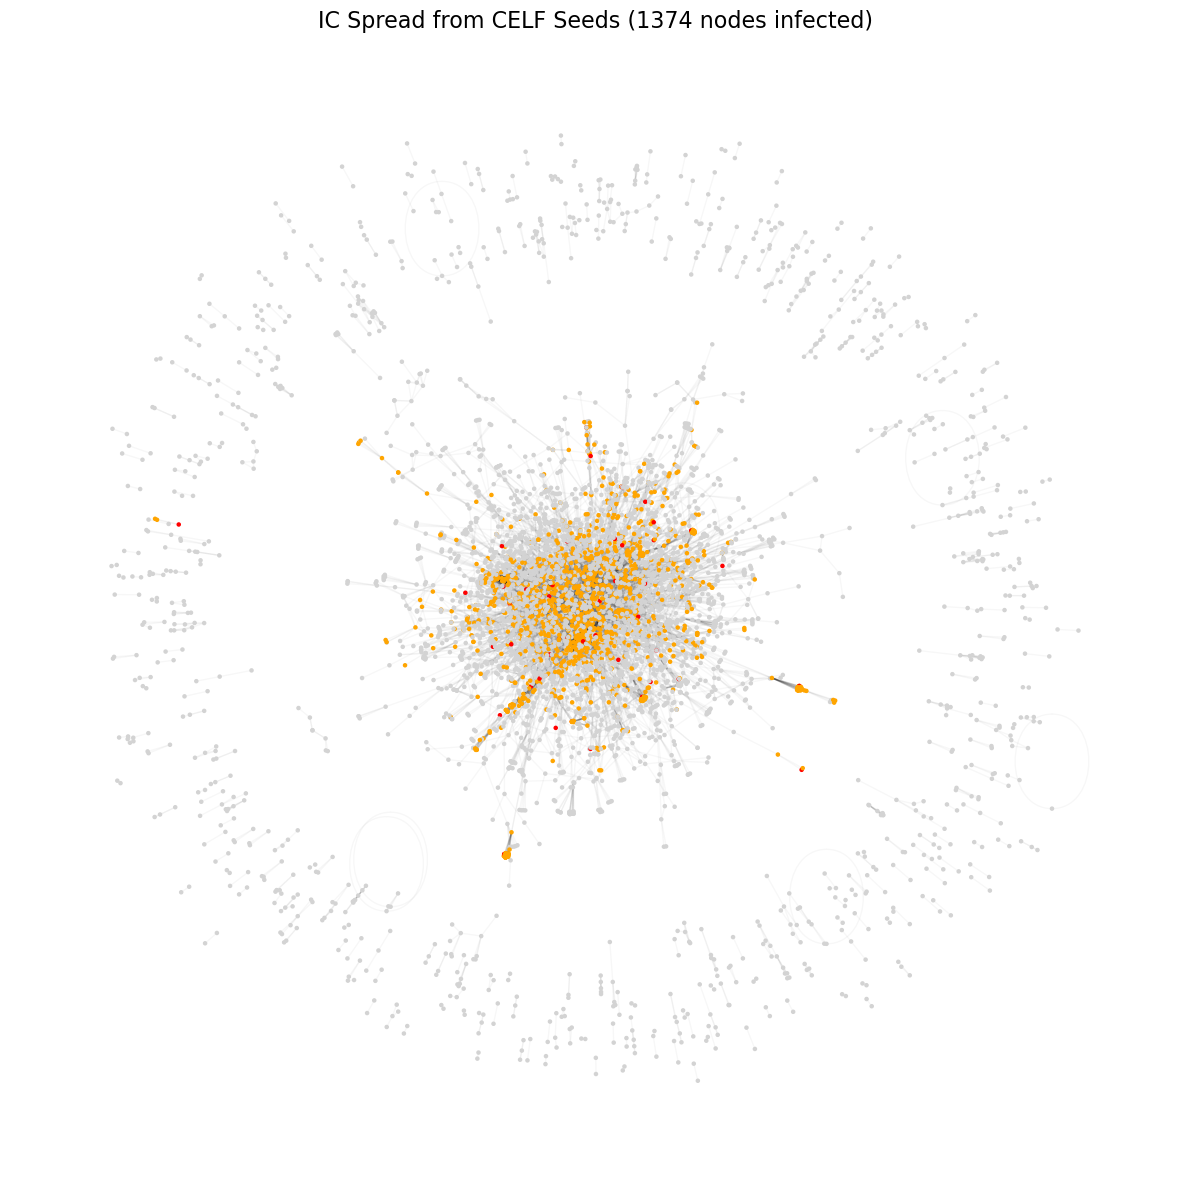

In [ ]:
random.seed(71)
N = G.number_of_nodes()
k = max(1, int(0.01 * N))
print(f"Total nodes: {N}, selecting k = {k} seeds...\n")
results = {}

# CELF Greedy seed selection
t0 = time.perf_counter()
seeds_celf_greedy = celf_seeds(G, k, steps=20, mc_runs=20)
t1 = time.perf_counter()
spread_celf_greedy = estimate_spread(G, seeds_celf_greedy, steps=20, mc_runs=1000)
activated_nodes = independent_cascade(G, seeds_celf_greedy, steps=20)
results['CELF'] = (t1-t0, spread_celf_greedy)
print(f"\nCELF Greedy seeds: {seeds_celf_greedy}")
print(f"CELF Greedy selection time: {t1-t0:.2f} seconds")
print(f"Estimated spread (CELF Greedy): {spread_celf_greedy:.1f}\n")

plt.figure(figsize=(10, 10))
node_colors = []
for n in G.nodes():
    if n in seeds_celf_greedy:
        node_colors.append("red")
    elif n in activated_nodes:
        node_colors.append("orange")
    else:
        node_colors.append("lightgray")

pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(G, pos, alpha=0.03)

plt.title(f"IC Spread from CELF Seeds ({len(activated_nodes)} nodes infected)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
# p = 0.2
# for u, v in G.edges():
#     G[u][v]['weight'] = p

# random.seed(71)
# steps = 40
# N = G.number_of_nodes()
# k = max(1, int(0.01 * N))
# print(f"Total nodes: {N}, selecting k = {k} seeds...\n")
# results = {}


# # CELF Greedy seed selection
# t0 = time.perf_counter()
# seeds_celf_greedy = celf_seeds(G, k, steps=steps, mc_runs=20)
# t1 = time.perf_counter()
# spread_celf_greedy = estimate_spread(G, seeds_celf_greedy, steps=steps, mc_runs=1000)
# results['CELF'] = (t1-t0, spread_celf_greedy)
# print(f"\nCELF Greedy seeds: {seeds_celf_greedy}")
# print(f"CELF Greedy selection time: {t1-t0:.2f} seconds")
# print(f"Estimated spread (CELF Greedy): {spread_celf_greedy:.1f}\n")

# # M-Greedy(with CELF) seed selection
# t0 = time.perf_counter()
# seeds_m_greedy = m_greedy_seeds(G, k, steps=steps, mc_runs=20)
# t1 = time.perf_counter()
# spread_m_greedy = estimate_spread(G, seeds_m_greedy, steps=steps, mc_runs=1000)
# results['M-greedy'] = (t1-t0, spread_m_greedy)
# print(f"\nM-Greedy seeds: {seeds_m_greedy}")
# print(f"M-Greedy selection time: {t1-t0:.2f} seconds")
# print(f"Estimated spread (M-Greedy): {spread_m_greedy:.1f}\n")

# # D-Greedy seed selection
# t0 = time.perf_counter()
# seeds_d_greedy = d_greedy_seeds(G, k, Rs=40)
# t1 = time.perf_counter()
# spread_d_greedy = estimate_spread(G, seeds_d_greedy, steps=steps, mc_runs=1000)
# results['D-greedy'] = (t1-t0, spread_d_greedy)
# print(f"\nD-Greedy seeds: {seeds_d_greedy}")
# print(f"D-Greedy selection time: {t1-t0:.2f} seconds")
# print(f"Estimated spread (D-Greedy): {spread_d_greedy:.1f}\n")

# # DegreeDiscountIC seed selection
# t0 = time.perf_counter()
# seeds_dd = degree_discount_ic(G, k, p)
# t1 = time.perf_counter()
# spread_dd = estimate_spread(G, seeds_dd, steps=steps, mc_runs=1000)
# results['DegreeDiscount'] = (t1-t0, spread_dd)
# print(f"DegreeDiscountIC seeds: {seeds_dd}")
# print(f"Degree Discount selection time: {t1-t0:.2f} seconds")
# print(f"Estimated spread (DegreeDiscount): {spread_dd:.1f}\n")

# # Expected Benefit
# t0 = time.perf_counter()
# seeds_eb = expected_benefit_seeds(G, k)
# t1 = time.perf_counter()
# spread_eb = estimate_spread(G, seeds_eb, steps=steps, mc_runs=1000)
# results['ExpectedBenefit'] = (t1-t0, spread_eb)
# print(f"Expected Benefit seeds: {seeds_eb}")
# print(f"Expected Benefit selection time: {t1-t0:.2f} seconds")
# print(f"Estimated spread (Expected Benefit): {spread_eb:.1f}\n")

# # Compare results
# for method, (sel_time, spread) in results.items():
#     print(f"{method}: selection_time={sel_time:.2f}s, spread={spread:.1f}")
# methods = ['CELFGreedy', 'M-Greedy', 'D-greedy', 'DegreeDiscount','ExpectedBenefit']
# spreads = [spread_celf_greedy, spread_m_greedy, spread_d_greedy, spread_dd, spread_eb]
# plt.bar(methods, spreads)
# plt.ylabel('Average # of activated nodes')
# plt.title('Seed Selection Comparison')
# plt.show()

In [8]:
p = 0.2
for u, v in G.edges():
    G[u][v]['weight'] = p

random.seed(71)
steps = 40
mc_sel = 20
mc_eval = 1000
N = G.number_of_nodes()
fractions = [0.002, 0.004, 0.006, 0.008, 0.01]
# k = max(1, int(0.01 * N))
# print(f"Total nodes: {N}, selecting k = {k} seeds...\n")
# results = {}
results_spread = {
    'CELF': [], 
    'M-greedy': [], 
    'D-greedy': [], 
    'DegreeDiscount': [], 
    'ExpectedBenefit': []
}
results_time = {
    'CELF': [], 
    'M-greedy': [], 
    'D-greedy': [], 
    'DegreeDiscount': [], 
    'ExpectedBenefit': []
}

for frac in fractions:
    k = max(1, int(frac * N))
    print(f"\n=== k fraction {frac} ⇒ k = {k} seeds ===")

    # CELF Greedy seed selection
    t0 = time.perf_counter()
    seeds_celf_greedy = celf_seeds(G, k, steps=steps, mc_runs=mc_sel)
    t1 = time.perf_counter()
    spread_celf_greedy = estimate_spread(G, seeds_celf_greedy, steps=steps, mc_runs=mc_eval)
    results_spread['CELF'].append(spread_celf_greedy)
    results_time['CELF'].append(t1-t0)
    # print(f"\nCELF Greedy seeds: {seeds_celf_greedy}")
    print(f"CELF Greedy selection time: {t1-t0:.2f} seconds")
    print(f"Estimated spread (CELF Greedy): {spread_celf_greedy:.1f}\n")

    # M-Greedy(with CELF) seed selection
    t0 = time.perf_counter()
    seeds_m_greedy = m_greedy_seeds(G, k, steps=steps, mc_runs=mc_sel)
    t1 = time.perf_counter()
    spread_m_greedy = estimate_spread(G, seeds_m_greedy, steps=steps, mc_runs=mc_eval)
    results_spread['M-greedy'].append(spread_m_greedy)
    results_time['M-greedy'].append(t1-t0)
    # print(f"\nM-Greedy seeds: {seeds_m_greedy}")
    print(f"M-Greedy selection time: {t1-t0:.2f} seconds")
    print(f"Estimated spread (M-Greedy): {spread_m_greedy:.1f}\n")

    # D-Greedy seed selection
    t0 = time.perf_counter()
    seeds_d_greedy = d_greedy_seeds(G, k, Rs=20)
    t1 = time.perf_counter()
    spread_d_greedy = estimate_spread(G, seeds_d_greedy, steps=steps, mc_runs=mc_eval)
    results_spread['D-greedy'].append(spread_d_greedy)
    results_time['D-greedy'].append(t1-t0)
    # print(f"\nD-Greedy seeds: {seeds_d_greedy}")
    print(f"D-Greedy selection time: {t1-t0:.2f} seconds")
    print(f"Estimated spread (D-Greedy): {spread_d_greedy:.1f}\n")

    # DegreeDiscountIC seed selection
    t0 = time.perf_counter()
    seeds_dd = degree_discount_ic(G, k, p)
    t1 = time.perf_counter()
    spread_dd = estimate_spread(G, seeds_dd, steps=steps, mc_runs=mc_eval)
    results_spread['DegreeDiscount'].append(spread_dd)
    results_time['DegreeDiscount'].append(t1-t0)
    # print(f"DegreeDiscountIC seeds: {seeds_dd}")
    print(f"Degree Discount selection time: {t1-t0:.2f} seconds")
    print(f"Estimated spread (DegreeDiscount): {spread_dd:.1f}\n")

    # Expected Benefit
    t0 = time.perf_counter()
    seeds_eb = expected_benefit_seeds(G, k)
    t1 = time.perf_counter()
    spread_eb = estimate_spread(G, seeds_eb, steps=steps, mc_runs=mc_eval)
    results_spread['ExpectedBenefit'].append(spread_eb)
    results_time['ExpectedBenefit'].append(t1-t0)
    # print(f"Expected Benefit seeds: {seeds_eb}")
    print(f"Expected Benefit selection time: {t1-t0:.2f} seconds")
    print(f"Estimated spread (Expected Benefit): {spread_eb:.1f}\n")




=== k fraction 0.002 ⇒ k = 10 seeds ===
CELF Greedy selection time: 415.38 seconds
Estimated spread (CELF Greedy): 1226.4

M-Greedy selection time: 244.03 seconds
Estimated spread (M-Greedy): 1218.4

D-Greedy selection time: 94.66 seconds
Estimated spread (D-Greedy): 1260.7

Degree Discount selection time: 0.01 seconds
Estimated spread (DegreeDiscount): 1169.0

Expected Benefit selection time: 0.15 seconds
Estimated spread (Expected Benefit): 1171.9


=== k fraction 0.004 ⇒ k = 20 seeds ===
CELF Greedy selection time: 325.73 seconds
Estimated spread (CELF Greedy): 1250.7

M-Greedy selection time: 211.90 seconds
Estimated spread (M-Greedy): 1204.0

D-Greedy selection time: 256.02 seconds
Estimated spread (D-Greedy): 1325.1

Degree Discount selection time: 0.03 seconds
Estimated spread (DegreeDiscount): 1235.6

Expected Benefit selection time: 0.50 seconds
Estimated spread (Expected Benefit): 1231.4


=== k fraction 0.006 ⇒ k = 31 seeds ===
CELF Greedy selection time: 475.25 seconds
Est

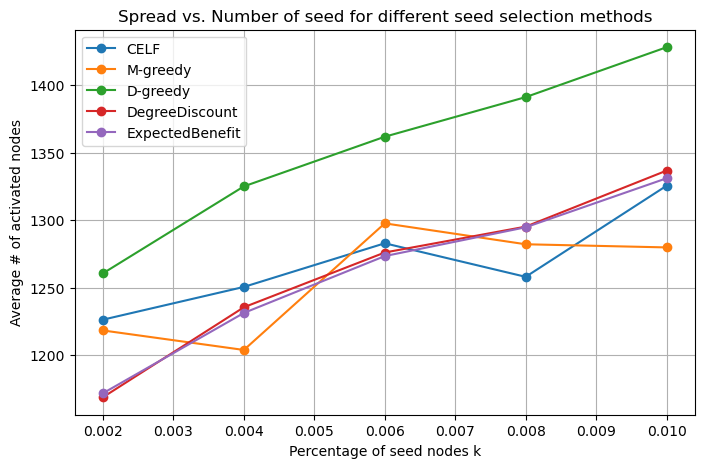

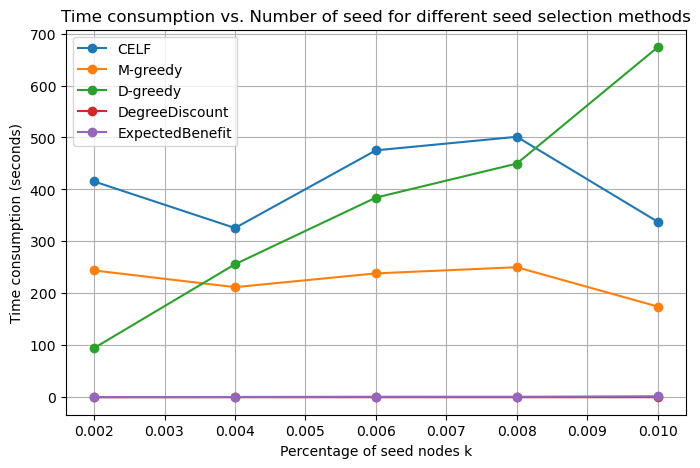

In [9]:
plt.figure(figsize=(8, 5))
for method, spreads in results_spread.items():
    plt.plot(fractions, spreads, marker='o', label=method)

plt.xlabel('Percentage of seed nodes k')
plt.ylabel('Average # of activated nodes')
plt.title('Spread vs. Number of seed for different seed selection methods')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
for method, time in results_time.items():
    plt.plot(fractions, time, marker='o', label=method)

plt.xlabel('Percentage of seed nodes k')
plt.ylabel('Time consumption (seconds)')
plt.title('Time consumption vs. Number of seed for different seed selection methods')
plt.legend()
plt.grid(True)
plt.show()

Linear Threshold Model

In [ ]:
common_num = {}
for u, v in G.edges():
    cn = len(set(G.neighbors(u)).intersection(G.neighbors(v)))
    common_num[(u, v)] = cn
    common_num[(v, u)] = cn  # 无向图

# 2. 对每个节点 v 做归一化，得到最终权重 w(u,v)
for v in G.nodes():
    nbrs = list(G.neighbors(v))
    total = sum(common_num[(u, v)] for u in nbrs)
    if total == 0:
        # 若所有公共邻居数都为 0，就退化为 1/deg(v)
        for u in nbrs:
            G[u][v]['weight'] = 1.0 / len(nbrs)
    else:
        for u in nbrs:
            G[u][v]['weight'] = common_num[(u, v)] / total

# 3. 定义 LT 模型的激活函数（示例：一次简单迭代模拟）
def linear_threshold(G, seeds, steps=10):
    activated = set(seeds)
    # 每个节点随机抽取阈值
    theta = {v: random.random() for v in G.nodes()}
    for step in range(steps):
        new_activated = []
        for v in G.nodes():
            if v in activated:
                continue
            # 计算累计影响 ∑_{u∈activated∩N(v)} w(u,v)
            influence = sum(G[u][v]['weight'] for u in G.neighbors(v) if u in activated)
            if influence >= theta[v]:
                new_activated.append(v)
        if not new_activated:
            break
        activated.update(new_activated)
    return activated

def estimate_spread_LT(G, seeds, steps=10, mc_runs=100):
    total = 0
    for _ in range(mc_runs):
        total += len(linear_threshold(G, seeds, steps))
    return total / mc_runs

def celf_seeds_LT(G, k, steps=10, mc_runs=100):
    # 初始化堆 (gain 的负值, 节点, 上次计算轮次)
    heap = []
    for v in G.nodes():
        spread_v = estimate_spread_LT(G, [v], steps, mc_runs)
        heap.append((-spread_v, v, 0))
    heapq.heapify(heap)

    S = []
    spread_S = 0.0
    lookups = 0

    for round_i in range(1, k + 1):
        while True:
            neg_gain, v, prev_round = heapq.heappop(heap)
            gain = -neg_gain
            # 如果上次计算 v 的增益是在上一轮完成的，则无需重算
            if prev_round == round_i - 1:
                S.append(v)
                spread_S += gain
                print(f"CELF-LT round {round_i}: pick {v}, marginal gain={gain:.2f}")
                break
            else:
                # 重新评估 v 的边际增益
                lookups += 1
                new_spread = estimate_spread_LT(G, S + [v], steps, mc_runs)
                new_gain = new_spread - spread_S
                heapq.heappush(heap, (-new_gain, v, round_i - 1))

    print(f"Total re-evaluations: {lookups}")
    return S

Total nodes: 5242, selecting k = 52 seeds...

CELF-LT round 1: pick 18208, marginal gain=1073.00
CELF-LT round 2: pick 13831, marginal gain=5.00
CELF-LT round 3: pick 7632, marginal gain=150.00
CELF-LT round 4: pick 3878, marginal gain=-67.00
CELF-LT round 5: pick 19954, marginal gain=-217.00
CELF-LT round 6: pick 22336, marginal gain=-183.00
CELF-LT round 7: pick 3033, marginal gain=210.00
CELF-LT round 8: pick 14485, marginal gain=-128.00
CELF-LT round 9: pick 6082, marginal gain=-24.00
CELF-LT round 10: pick 23363, marginal gain=-51.00
CELF-LT round 11: pick 23134, marginal gain=253.00
CELF-LT round 12: pick 11372, marginal gain=4.00
CELF-LT round 13: pick 19475, marginal gain=72.00
CELF-LT round 14: pick 2506, marginal gain=-228.00
CELF-LT round 15: pick 15145, marginal gain=340.00
CELF-LT round 16: pick 20667, marginal gain=-235.00
CELF-LT round 17: pick 16224, marginal gain=-43.00
CELF-LT round 18: pick 4416, marginal gain=-94.00
CELF-LT round 19: pick 22691, marginal gain=142.00

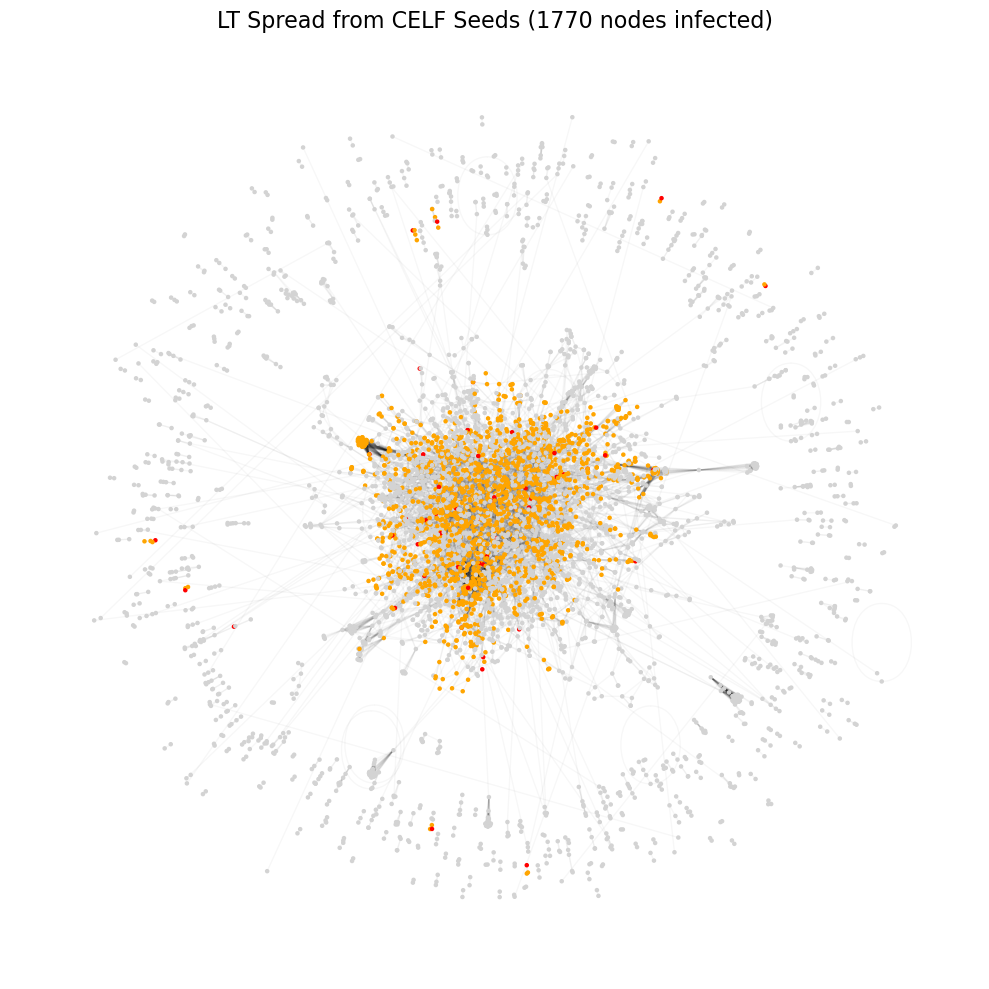

In [12]:
random.seed(71)
N = G.number_of_nodes()
k = max(1, int(0.01 * N))
print(f"Total nodes: {N}, selecting k = {k} seeds...\n")
results = {}

# CELF Greedy seed selection
t0 = time.perf_counter()
seeds_celf_greedy = celf_seeds_LT(G, k, steps=20, mc_runs=1)
t1 = time.perf_counter()
spread_celf_greedy = estimate_spread_LT(G, seeds_celf_greedy, steps=20, mc_runs=10)
activated_nodes = linear_threshold(G, seeds_celf_greedy, steps=20)
results['CELF'] = (t1-t0, activated_nodes)
print(f"\nCELF Greedy seeds: {seeds_celf_greedy}")
print(f"CELF Greedy selection time: {t1-t0:.2f} seconds")
print(f"Estimated spread (CELF Greedy): {spread_celf_greedy:.1f}\n")

plt.figure(figsize=(10, 10))
node_colors = []
for n in G.nodes():
    if n in seeds_celf_greedy:
        node_colors.append("red")
    elif n in activated_nodes:
        node_colors.append("orange")
    else:
        node_colors.append("lightgray")

pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(G, pos, alpha=0.03)

plt.title(f"LT Spread from CELF Seeds ({len(activated_nodes)} nodes infected)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

Discrete Time SI + Multi-hop Decay Model

In [16]:
def discrete_SI_with_attenuation(G, seeds, alpha=0.8, steps=10):

    activated = set(seeds)
    node_hop = {s: 1 for s in seeds}
    
    for _ in range(steps):
        next_new = []
        # 在每个时隙，对 G 中所有已激活节点 u 做尝试
        for u in list(activated):
            hop_u = node_hop[u]
            for v in G.neighbors(u):
                if v not in activated:
                    p_eff = G[u][v]['weight'] * (alpha ** (hop_u - 1))
                    if random.random() <= p_eff:
                        activated.add(v)
                        node_hop[v] = hop_u + 1
                        next_new.append(v)
        if not next_new:
            break
    
    return activated

# ——— 2. Monte Carlo 估算传播规模 ———
def estimate_spread_DSIA(G, seeds, alpha=0.8, steps=10, mc_runs=100):
    total = 0
    for _ in range(mc_runs):
        total += len(discrete_SI_with_attenuation(G, seeds, alpha, steps))
    return total / mc_runs

# ——— 3. CELF 优化的 Greedy 选种（基于 DSIA + Monte Carlo） ———
def celf_seeds_DSIA(G, k, alpha=0.8, steps=10, mc_runs=10):
    # 1. 初始化堆：对每个节点 v 先估算 singleton {v} 的扩散规模
    heap = []
    for v in G.nodes():
        spread_v = estimate_spread_DSIA(G, [v], alpha, steps, mc_runs)
        # 堆里存 (-gain, 节点, 上次计算轮次)
        heap.append((-spread_v, v, 0))
    heapq.heapify(heap)

    S = []
    spread_S = 0.0     # 当前种子集的估计传播规模
    lookups = 0        # 重新评估次数统计

    # 2. 依次选 k 个种子
    for round_i in range(1, k + 1):
        while True:
            neg_gain, v, prev_round = heapq.heappop(heap)
            gain = -neg_gain
            # 如果上次计算是在上一轮 round_i-1 完成的，则直接接受 v
            if prev_round == round_i - 1:
                S.append(v)
                spread_S += gain
                print(f"CELF-DSIA round {round_i}: pick {v}, marginal gain={gain:.2f}")
                break
            else:
                # 否则，重新估算 v 加入当前 S 后的增益
                lookups += 1
                new_spread = estimate_spread_DSIA(G, S + [v], alpha, steps, mc_runs)
                new_gain = new_spread - spread_S
                # 更新堆项，标记本次计算发生在 round_i-1
                heapq.heappush(heap, (-new_gain, v, round_i - 1))

    print(f"Total re-evaluations: {lookups}")
    return S



Total nodes: 5242, selecting k = 52 seeds...

CELF-DSIA round 1: pick 2654, marginal gain=3966.40
CELF-DSIA round 2: pick 9572, marginal gain=32.40
CELF-DSIA round 3: pick 13801, marginal gain=16.80
CELF-DSIA round 4: pick 14599, marginal gain=19.00
CELF-DSIA round 5: pick 6830, marginal gain=8.60
CELF-DSIA round 6: pick 23946, marginal gain=8.40
CELF-DSIA round 7: pick 20926, marginal gain=7.80
CELF-DSIA round 8: pick 20375, marginal gain=7.80
CELF-DSIA round 9: pick 10252, marginal gain=4.40
CELF-DSIA round 10: pick 24732, marginal gain=-0.40
CELF-DSIA round 11: pick 25050, marginal gain=0.00
CELF-DSIA round 12: pick 3927, marginal gain=-0.60
CELF-DSIA round 13: pick 6376, marginal gain=10.00
CELF-DSIA round 14: pick 11610, marginal gain=-0.60
CELF-DSIA round 15: pick 8726, marginal gain=-0.80
CELF-DSIA round 16: pick 13384, marginal gain=-0.40
CELF-DSIA round 17: pick 25785, marginal gain=0.60
CELF-DSIA round 18: pick 26141, marginal gain=1.60
CELF-DSIA round 19: pick 11823, margina

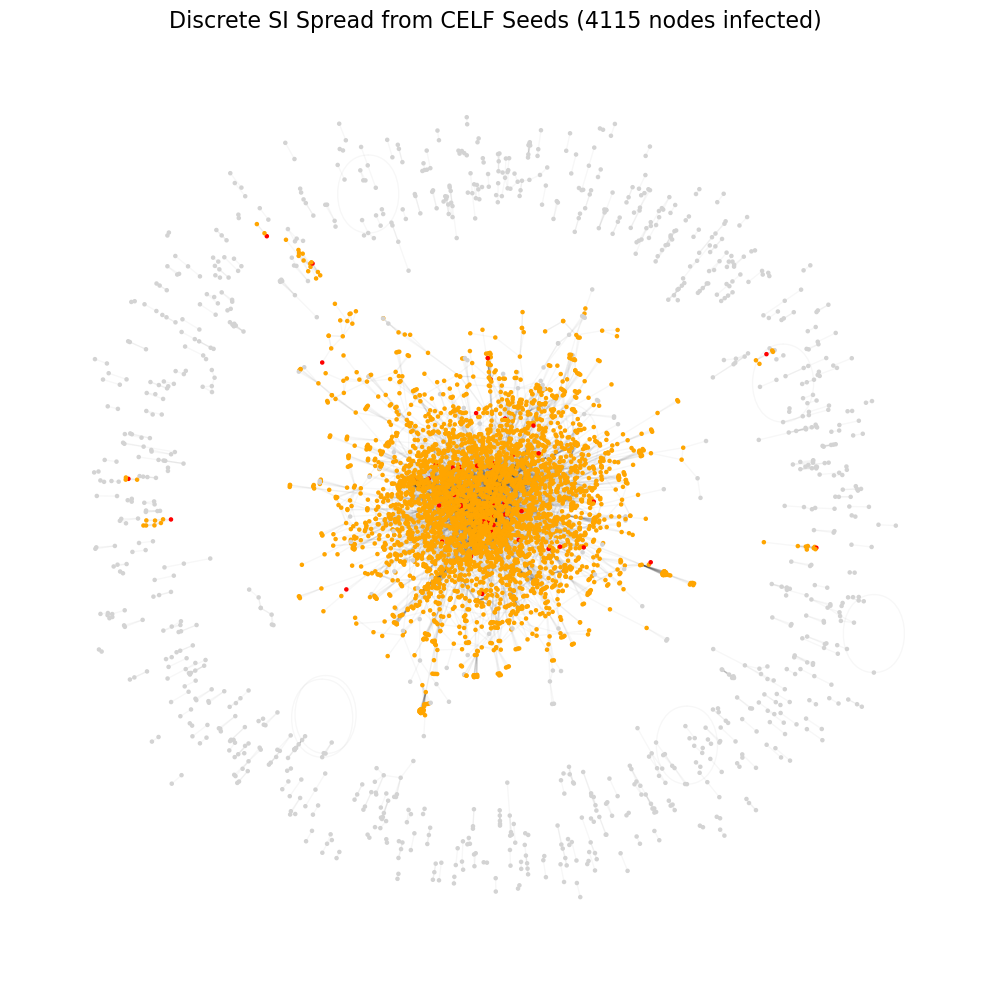

In [17]:
p = 0.2
for u, v in G.edges():
    G[u][v]['weight'] = p

random.seed(71)
N = G.number_of_nodes()
alpha = 1
steps = 20
k = max(1, int(0.01 * N))
print(f"Total nodes: {N}, selecting k = {k} seeds...\n")
results = {}

# CELF Greedy seed selection
t0 = time.perf_counter()
seeds_celf_greedy = celf_seeds_DSIA(G, k, alpha=alpha, steps=steps, mc_runs=5)
t1 = time.perf_counter()
spread_celf_greedy = estimate_spread_DSIA(G, seeds_celf_greedy, alpha=alpha, steps=steps, mc_runs=100)
activated_nodes = discrete_SI_with_attenuation(G, seeds_celf_greedy, alpha=alpha, steps=steps)
results['CELF'] = (t1-t0, spread_celf_greedy)
print(f"\nCELF Greedy seeds: {seeds_celf_greedy}")
print(f"CELF Greedy selection time: {t1-t0:.2f} seconds")
print(f"Estimated spread (CELF Greedy): {spread_celf_greedy:.1f}\n")

plt.figure(figsize=(10, 10))
node_colors = []
for n in G.nodes():
    if n in seeds_celf_greedy:
        node_colors.append("red")
    elif n in activated_nodes:
        node_colors.append("orange")
    else:
        node_colors.append("lightgray")

pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(G, pos, alpha=0.03)

plt.title(f"Discrete SI Spread from CELF Seeds ({len(activated_nodes)} nodes infected)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()